In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}
'''
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap
'''

'\nfrom matplotlib.colors import LinearSegmentedColormap\n# Define the color map\ncolors = [\'#dadaeb\',\'#6a51a3\']\ncustom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)\ncmm=custom_cmap\n'

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

In [6]:
# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [7]:
long_data = m_df.copy()

In [8]:
## MI for identity in longtogeny

In [9]:
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('age'))
mi_score_long = MIR(X,y)

In [10]:
long_indx = np.argsort(mi_score_long)[::-1][0:len(keep_syllables)] # syllble index
impsyl_long= list(long_data.columns[long_indx]) #syllable id

In [11]:
# Number of bins
n_bins = 15  # Define the number of bins

# Reset the index to work with 'age' as a column
long_df_reset = long_data.reset_index()

# Create bins for 'age'
long_df_reset['bins'] = pd.cut(long_df_reset['age'], bins=n_bins)

# Calculate the mean age for each bin
bin_means = long_df_reset.groupby('bins')['age'].mean().astype(int)

# Map the mean ages back to the DataFrame
long_df_reset['bins'] = long_df_reset['bins'].map(bin_means)

# If you want to set the multi-index back
long_df_reset.set_index(['mouse', 'age','bins'], inplace=True)

long_data=long_df_reset.copy()

In [12]:
sy=[]
mi=[]
age=[]
for b,_df in long_data.groupby('bins'):
    X = _df.to_numpy()
    y = list(_df.index.get_level_values('mouse'))
    mi_score_id = MIC(X,y)
    sy.extend(_df.columns)
    mi.extend(mi_score_id)
    age.extend([b]*len(mi_score_id))

In [13]:
mi_df = pd.DataFrame()
mi_df['mi'] = mi
mi_df['syll'] = sy
mi_df['age'] = age
# Group by age, syllable, and mi, and calculate the mean
grouped_df = mi_df.groupby(['age', 'syll', 'mi']).mean().reset_index()

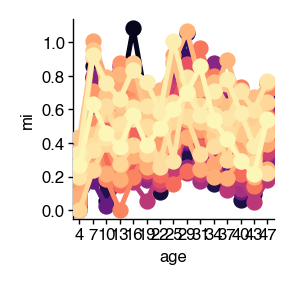

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1.3)

#sns.pointplot(data=mi_df,x='exp',y='mi',hue='syll',join=True, palette='magma', hue_order=impsyl_long)
sns.pointplot(data=grouped_df,x='age',y='mi',hue='syll',join=True, palette='magma')

sns.despine()
# Remove the legend
plt.legend().remove()
c = PlotConfig()

In [15]:
# Ensure all columns in impsyl_id are present in the DataFrame

heatmap_df = grouped_df.pivot(index='syll', columns='age', values='mi')
# Ensure all indices in impsyl_long are present in the DataFrame
assert set(impsyl_long) <= set(heatmap_df.index), "impsyl_long contains rows not present in heatmap_df"

# Reorder the rows according to impsyl_long
heatmap_df = heatmap_df.loc[impsyl_long]

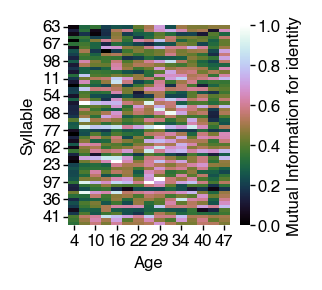

In [16]:
# Plot the heatmap
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1.3)
sns.heatmap(heatmap_df, cmap='cubehelix', cbar_kws={'label': 'Mutual Information for identity'}, vmax=1, ax=ax)
plt.xlabel('Age')
plt.ylabel('Syllable')
#plt.title('Mutual Information Heatmap')
plt.show()

In [17]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'MI_over_life_longv2.pdf')